# Using classifiers to improve business operation

This project is dedicated to a clothing chain in New England, which has collected data from the last-year mailing campaign. We are experts in custom relations and in clothing stores in general. Our goal is to apply machine learning and data science skills to improve the future mailing campaign.

To increase profit this year, we want to take a new dataset of potential subscribers, and predict their response using classification modelx and target only the group with high probability to respond.

## 1. Machine Learning
### 1.1.Data preparation

In [12]:
import pandas as pd
import numpy as np

file_name = "./data/Clothing_Store.csv"
data = pd.read_csv(file_name)
data.columns

Index(['CUSTOMER_ID', 'ZIP_CODE', 'TOTAL_VISITS', 'TOTAL_SPENT',
       'AVRG_SPENT_PER_VISIT', 'HAS_CREDIT_CARD', 'PSWEATERS', 'PKNIT_TOPS',
       'PKNIT_DRES', 'PBLOUSES', 'PJACKETS', 'PCAR_PNTS', 'PCAS_PNTS',
       'PSHIRTS', 'PDRESSES', 'PSUITS', 'POUTERWEAR', 'PJEWELRY', 'PFASHION',
       'PLEGWEAR', 'PCOLLSPND', 'AMSPEND', 'PSSPEND', 'CCSPEND', 'AXSPEND',
       'SPEND_LAST_MONTH', 'SPEND_LAST_3MONTH', 'SPEND_LAST_6MONTH',
       'SPENT_LAST_YEAR', 'GMP', 'PROMOS_ON_FILE', 'DAYS_ON_FILE', 'FREQ_DAYS',
       'MARKDOWN', 'PRODUCT_CLASSES', 'COUPONS', 'STYLES', 'STORES',
       'STORELOY', 'VALPHON', 'WEB', 'MAILED', 'RESPONDED', 'RESPONSERATE',
       'LTFREDAY', 'CLUSTYPE', 'PERCRET', 'RESP'],
      dtype='object')

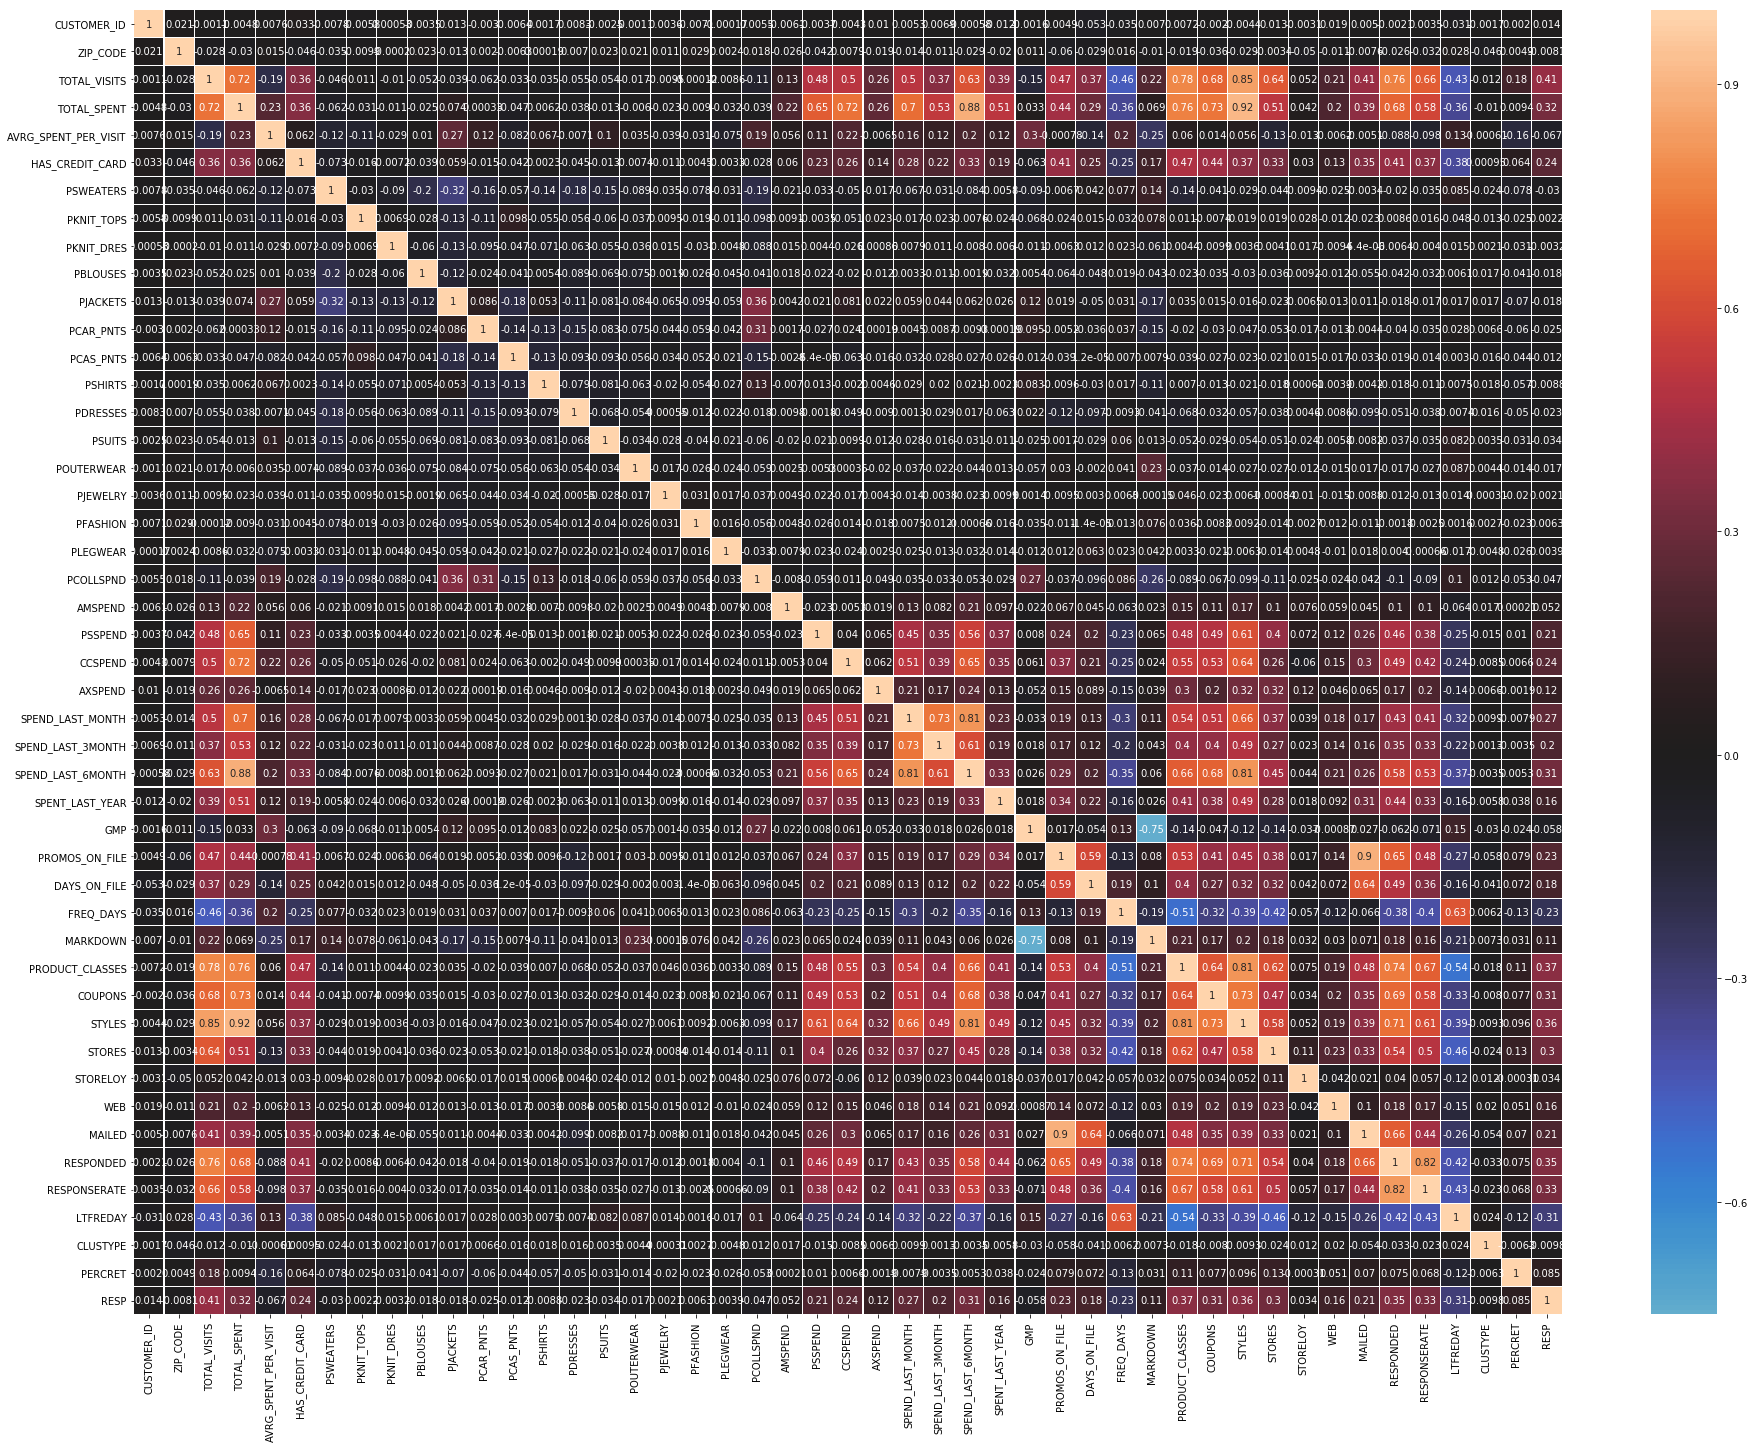

In [13]:
# Heatmap to show correlation between attributes
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(32,24)) 
corr = data.corr()
sns.heatmap(corr, center=0, annot=True, linewidths=.1, ax=ax)

We first drop irrelevant attribute from the dataset
* Remove CUSTOMER_ID: it's for indexing and has no meaning

* Remove PSWEATERS, PKNIT_TOPS...: We concern more about in general if customers respond to our compaign but care less about which specific type of clothes do customers prefer. Besides, according to the heat map above, the correlation between PSWEATERS, PKNIT_TOPS... and out target variable is about 0.01, so basically no correaltion

* Remove SPEND_LAST_3MONTH, SPEND_LAST_6MONTH: This two attributes highly correlate with SPEND_LAST_MONTH(short term shopping), SPENT_LAST_YEAR(long term shopping). Also according to the heat map, the correlation between these attribuets > 0.7, so we don't need to keep all of them

* Remove MAILED: MAILED = RESPONDED / RESPONSERATE. It completely overlap with the other two attributes

In [14]:
# drop the irrelevant attribute
data = data.drop(columns=['CUSTOMER_ID'])

data = data.drop(columns=['PSWEATERS', 'PKNIT_TOPS',
       'PKNIT_DRES', 'PBLOUSES', 'PJACKETS', 'PCAR_PNTS', 'PCAS_PNTS',
       'PSHIRTS', 'PDRESSES', 'PSUITS', 'POUTERWEAR', 'PJEWELRY', 'PFASHION',
       'PLEGWEAR', 'PCOLLSPND'])

data = data.drop(columns=['SPEND_LAST_3MONTH', 'SPEND_LAST_6MONTH'])

data = data.drop(columns=['MAILED'])

We then work with each attribute individually:   
reduce cardinality of ZIP_CODE & convert VALPHON into numeric

In [15]:
# reduce zip code cardinality by relabelling
data['ZIP_CODE'] = data['ZIP_CODE'].floordiv(10000)

# convert VALPHON into numeric attribute
data['VALPHON'] = [1 if x == 'Y' else 0 for x in data['VALPHON']]

Since there's too many CLUSTYPE, we want to reduce its cardinality by leaving only several most common, and putting all the others into a category ‘other' 

In [16]:
# reduce CLUSTYPE cardinality by relabelling
clus_df = data.groupby('CLUSTYPE').count().sort_values('ZIP_CODE',ascending=False)
clus_df = clus_df['ZIP_CODE'].reset_index()
clus_df['PERCENT'] = [x / np.sum(clus_df['ZIP_CODE']) for x in clus_df['ZIP_CODE']]
clus_df.columns = ['CLUSTYPE','NUM_OF_CUSTOMERS','PERCENT']
clus_df['RELABEL'] = clus_df.index
# print(clus_df)

rm_ls = clus_df[clus_df['PERCENT'] < 0.03]['CLUSTYPE'].to_list()
print(rm_ls)
print(clus_df[clus_df['PERCENT'] < 0.03]['PERCENT'].sum())

data['CLUSTYPE'] = [-1 if x in rm_ls else x for x in data['CLUSTYPE']]
data['CLUSTYPE'] = [clus_df[clus_df['CLUSTYPE']==x]['RELABEL'].iloc[0] if x!=-1 else 13 for x in data['CLUSTYPE']]
print(data[data['CLUSTYPE']==13].count().iloc[0]/data.count().iloc[0])

[6, 25, 20, 24, 35, 50, 22, 28, 2, 32, 39, 40, 17, 14, 7, 13, 46, 45, 36, 42, 30, 41, 37, 29, 34, 48, 21, 31, 0, 43, 9, 47, 27, 49, 26, 19, 33, 44]
0.2698712051517939
0.2698712051517939


Because there's much more numeric values, we want to convert CLUSTYPE and ZIP into numeric and choose classifies that can handle numeric values later

In [17]:
# convert catogorical into numeric attributes
clus_ls = ['CLUSTYPE'+str(i) for i in range(14)]
zip_ls = ['ZIP'+str(i) for i in range(10)]

for i in range(len(clus_ls)):
    col = clus_ls[i]
    data[col] = [1 if x == i else 0 for x in data['CLUSTYPE']]

for i in range(len(zip_ls)):
    col = zip_ls[i]
    data[col] = [1 if x == i else 0 for x in data['ZIP_CODE']]
    
data = data.drop(columns=['CLUSTYPE','ZIP_CODE'])

We apply normalization to entire dataset for better classification result

In [18]:
# Normalization
for col in data.columns:
    data[col] = (data[col]-data[col].min())/(data[col].max()-data[col].min())
    
data.to_csv("./data/business_input.csv", index = False)

### 1.2.Comparing classifiers

We then build the model of both naive_bayes and DecisionTreeClassifier, train and test both models with cross validation and compare the accuracy of different classifiers. (P.S this may take a long time)

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
MultNB = MultinomialNB()
X = data.drop(columns=["RESP"])
Y = data["RESP"]

'''
grid_dictionary = {'n_neighbors':np.arange(1,50)}
gs = GridSearchCV(gnb, grid_dictionary,cv=20)
print(gs)
'''

parameters={'class_prior':[[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.4,0.6]]}
gs= GridSearchCV(MultNB,parameters,scoring='accuracy')
print(gs)

gs_result = gs.fit(X,Y)
print(gs_result.best_params_)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'class_prior': [[0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6]]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)


E:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'class_prior': [0.4, 0.6]}


After finding out the best k for KNN with grid search, we take the k as parameter and compute the performance interval with 90% confidence.

In [24]:
from sklearn.model_selection import cross_val_score
import math

MultNB = MultinomialNB(class_prior=[0.4, 0.6])

MultNB_cv_scores = cross_val_score(MultNB, X, Y, cv=20)
mean_score = np.mean(MultNB_cv_scores)
std_dev = MultNB_cv_scores.std()
true_std = std_dev / math.sqrt(MultNB_cv_scores.shape[0])
lower_bound = mean_score - 1.64 * true_std
upper_bound = mean_score + 1.64 * true_std

print(MultNB_cv_scores)
print('MultNB: accuracy in [{:.4f} , {:.4f}] with 90% confidence'.format(lower_bound,upper_bound))


[0.82261029 0.64430147 0.65441176 0.69485294 0.67555147 0.69025735
 0.69301471 0.63878676 0.60477941 0.59889604 0.59889604 0.4907919
 0.57734807 0.59300184 0.56629834 0.6427256  0.7679558  0.76703499
 0.74769797 0.7053407 ]
MultNB: accuracy in [0.6300 , 0.6875] with 90% confidence


Similarly, we train the DecisionTreeClassifier, model and test it with cross validation, and compute its accuracy interval with 90% confidence

In [25]:
from sklearn.tree import DecisionTreeClassifier
# Train the DecisionTreeClassifier classifier
dtc = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3)
fitted_model = dtc.fit(X, Y)

In [26]:
dtc_cv_scores = cross_val_score(fitted_model, X, Y, cv=20)
mean_score = np.mean(dtc_cv_scores)
std_dev = dtc_cv_scores.std()
true_std = std_dev / math.sqrt(dtc_cv_scores.shape[0])
lower_bound = mean_score - 1.64 * true_std
upper_bound = mean_score + 1.64 * true_std

print(dtc_cv_scores)
print('DecisionTreeClassifier: accuracy in [{:.4f} , {:.4f}] with 90% confidence'.format(lower_bound,upper_bound))


[0.80790441 0.79319853 0.78400735 0.78584559 0.80882353 0.82352941
 0.80514706 0.77757353 0.80147059 0.80864765 0.81324747 0.78268877
 0.79742173 0.79189687 0.78360958 0.7854512  0.8121547  0.81767956
 0.79005525 0.80018416]
DecisionTreeClassifier: accuracy in [0.7938 , 0.8033] with 90% confidence


We compare performance of different classifiers by null hypothesis and t test

In [28]:
mean_dif_arr = np.array([MultNB_cv_scores[i]-dtc_cv_scores[i] for i in range(len(dtc_cv_scores))])
mean_dif = mean_dif_arr.mean()
print("mean difference: ", mean_dif)

var_dif_arr = np.array([(x-mean_dif)**2 for x in mean_dif_arr])
var_dif = var_dif_arr.sum() / (len(var_dif_arr)-1)
std_dif = math.sqrt(var_dif) / math.sqrt(len(var_dif_arr))
print(std_dif)

lower_bound = - 2.101 * std_dif
upper_bound = 2.101 * std_dif

print('For two classifiers to have true accuracy difference with 90% confidence')
print('mean difference should be outside [{:.4f} , {:.4f}]'.format(lower_bound,upper_bound))
print('We can tell that DecisionTreeClassifier is significantly better than MultinomialNB with 90% confidence')


mean difference:  -0.1397991726204909
0.016910845419206753
For two classifiers to have true accuracy difference with 90% confidence
mean difference should be outside [-0.0355 , 0.0355]
We can tell that DecisionTreeClassifier is significantly better than MultinomialNB with 90% confidence


In [36]:
result_df = pd.DataFrame(columns=['index','actual','predicted','probability','cumulative_pos'])


result_df['actual'] = data['RESP']
result_df['predicted'] = fitted_model.predict(X)
result_df['index'] = result_df.index

result_df['probability'] = fitted_model.predict_proba(X)[:,1]

result_df['index'] = result_df['index'] + 1

cum_ls = []
cum_ls.append(int(result_df['actual'].iloc[0]))
for i in range(1,len(result_df)):
    cum_ls.append(int(result_df['actual'].iloc[i] + cum_ls[i-1]))

result_df['cumulative_pos'] = cum_ls

result_df.to_csv("./data/business_result.csv", index = False)

Our DecisionTreeClassifier model has already obtained about 80% accuracy and its performance is good enough for business analysis. To further improve our model, we can apply some feature selection algorithm or add more expert knowledge to increase the weight of key features. 
  
Also, because DecisionTreeClassifier outputs the probability of our input belongs to a class, we can use the ROC curve to improve the performance. By assusming a cost matrix, we can sort our outputs by probability and for different threshold values we get different points in the ROC space and select the one with best accuracy.  
  
Finally, we label all our inputs with prediction and its probability (also actual value, cumulative positive reponds, index) and store it in business_result.csv

## 2 Business analysis
### 2.1 Lift chart
We sort the new dataset by the predicted class from Yes to No and then by probability from highest to the lowest. We can then compare customers' positive responses using the top of predicted list with the same number of randomly selected customers and visualize it with lift chart. 


In [37]:
sorted_df = result_df.sort_values(by=['predicted','probability'],ascending=False)
print(sorted_df)

       index  actual  predicted  probability  cumulative_pos
1          2     1.0        1.0          1.0               1
9         10     1.0        1.0          1.0               2
28        29     1.0        1.0          1.0               4
31        32     1.0        1.0          1.0               5
46        47     1.0        1.0          1.0               7
...      ...     ...        ...          ...             ...
21732  21733     0.0        0.0          0.0            3609
21733  21734     0.0        0.0          0.0            3609
21734  21735     0.0        0.0          0.0            3609
21735  21736     0.0        0.0          0.0            3609
21736  21737     0.0        0.0          0.0            3609

[21740 rows x 5 columns]


After sorting, we count the cumulative positive responses for the sorted list of customers and output it as business_result_sorted.csv

In [38]:
sorted_df['cumul_pos'] = 0
sorted_df = sorted_df.drop(columns=['cumulative_pos'])

cum_ls = []
cum_ls.append(int(sorted_df['actual'].iloc[0]))
for i in range(1,len(sorted_df)):
    cum_ls.append(int(sorted_df['actual'].iloc[i] + cum_ls[i-1]))

sorted_df['cumul_pos'] = cum_ls

sorted_df.to_csv("./data/business_result_sorted.csv", index = False)

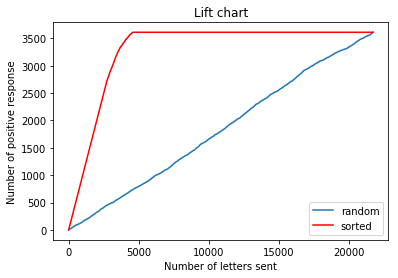

Total number of customers: 21740, Total number of positive response: 3611
By sending mails to 7750 customers, we are expected to receive
1257 positive responses if we send to randomly selected customers
3611 positive responses if we send to top of predicted list


In [39]:
plt.title("Lift chart")
plt.xlabel("Number of letters sent")
plt.ylabel("Number of positive response")

plt.plot(list(result_df['index']),list(result_df['cumulative_pos']),label="random")
plt.plot(list(result_df['index']),list(sorted_df['cumul_pos']),c='red',label="sorted")
plt.legend(loc='best')

plt.show()

print("Total number of customers: {}, Total number of positive response: {}".format(len(sorted_df),sorted_df['cumul_pos'].iloc[-1]))
print("By sending mails to 7750 customers, we are expected to receive")
print("{} positive responses if we send to randomly selected customers".format(result_df['cumulative_pos'].iloc[7750]))
print("{} positive responses if we send to top of predicted list".format(sorted_df['cumul_pos'].iloc[7750]))


Analyzing this chart, we can see that by sending mails to only 7750/21740 = 35.65% of the customers from the top of the ranked list, we should be able to cover 2889/3611= 80% of potential responders. 


### 2.2 Cost-benefit analysis
In order to choose the optimal number of letters to send, we assume the cost and benefit of each (positive) responds. Based on this assumption we compute the cost, revenue and profit for both mailing to customers in the sorted list and randomly.  
  
Our cost, revenue and profit for mailing to customers in the sorted list is recorded in business_result_final.csv 

E:\Anaconda3\lib\site-packages\pandas\core\indexes\range.py:720: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)
E:\Anaconda3\lib\site-packages\matplotlib\cbook.py:2224: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
E:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:252: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


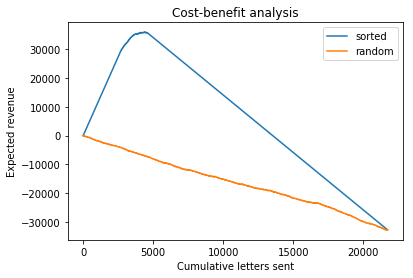

Maximum profit:  36009
Cumulative letters sent:  4403


In [42]:
sorted_df = sorted_df.reset_index()
sorted_df = sorted_df.drop(columns=['level_0'])

sorted_df['cost'] = 4 * (sorted_df.index+1)
sorted_df['revenue'] = 15 * sorted_df['cumul_pos']
sorted_df['profit'] = sorted_df['revenue'] - sorted_df['cost']
sorted_df.to_csv("./data/business_result_final.csv", index = False)

plt.title("Cost-benefit analysis")
plt.xlabel("Cumulative letters sent")
plt.ylabel("Expected revenue")

plt.plot(sorted_df.index, sorted_df['profit'],label='sorted')

result_df['cost'] = 4 * (result_df.index+1)
result_df['revenue'] = 15 * result_df['cumulative_pos']
result_df['profit'] = result_df['revenue'] - result_df['cost']
result_df.to_csv("./data/result2.csv", index = False)

plt.plot(result_df.index, result_df['profit'],label='random')
plt.legend(loc='best')
plt.show()

max_profit = max(sorted_df['profit'])
cum_letter = sorted_df[sorted_df['profit']==max_profit].index.values[0]
print("Maximum profit: ", max_profit)
print("Cumulative letters sent: ", cum_letter)

With our new model, we can find that the optimal number of mails sent should be 4403 from the sorted list to create the maximum profit of \\$36009. Before when we mail promotion randomly, for sending 4403 mails our profit would be -$8843. So applying this new way of targeting customers to promote would increase our profit by \\$22701. 
